<a href="https://colab.research.google.com/github/camiscf/music-recommendation-system/blob/main/versaoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação de Música usando cosseno e distância

O projeto consiste em um sistema de recomendação de música a partir de dados obtidos através da API do *spotify*  e utilizando o conhecimento da disciplina, especificamente o cosseno e a distância entre vetores, para determinar as melhores recomendações respectiva a cada método.

## Como testar ?
Basta pegar a URL da música no spotify e colocar no [Input do usuário](https://colab.research.google.com/drive/1vZ5TUh9i1geVfa97mpf6gxIr4Cqb1vGa?authuser=2#scrollTo=DZI67IU964cs&line=2&uniqifier=1), o resultado será apresentado na [planilha](https://docs.google.com/spreadsheets/d/1wkFn7QA0GikDUm3trbQKotx6KdGhYwsvu1XET3PGSVI/edit#gid=2074096667) \\

\

#####**Mais sobre o trabalho**
[Relatório completo](https://drive.google.com/file/d/1E1swqQanZuXoNg4UAcX6JDNkN0_BVc2r/view?usp=sharing)

# Instalação
Foi utilizada a biblioteca *spotipy* para trabalhar com as músicas e a *pygsheets* para escrever o resultado na planilha


In [31]:
!pip install spotipy
!pip install pygsheets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importações

In [32]:
# API 
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json

# COLAB 
from google.colab import drive, files
import io
import pygsheets


# DADOS
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.metrics.pairwise import cosine_similarity


# Autenticação

Informação necessária para fazer os requests na API

In [33]:
cid = '6eb385abeb61467ba564419872185201'
secret = '1687cec7ce7f4b2fa357dd7cdc4a15e2'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Gêneros

Para montar o universo de músicas as quais serão utilizadas para retonar as recomendações foi selecionado alguns gêneros musicais.


In [34]:
#acoustic, bossanova, heavy-metal, electronic, forro, funk, indie-pop, indie, k-pop, pop, clássico, MPB, Samba, Pagode, rock
acoustic = '37i9dQZF1DWXRvPx3nttRN'
bossanova = '37i9dQZF1DX4AyFl3yqHeK'
heavy_metal = '37i9dQZF1DX9qNs32fujYe'
electronic = '37i9dQZF1EQp9BVPsNVof1'
forro = '37i9dQZF1DWZMthVIHWet5'
funk = '37i9dQZF1DWTkIwO2HDifB'
indie_pop = '37i9dQZF1DWWEcRhUVtL8n'
indie = '37i9dQZF1EQqkOPvHGajmW'
k_pop = '37i9dQZF1DX9tPFwDMOaN1'
pop = '37i9dQZF1DX6aTaZa0K6VA'
classico = '37i9dQZF1DWWEJlAGA9gs0'
mpb = '37i9dQZF1DWZ8wKkpiPwjx'
samba = '37i9dQZF1DWTUHOvJwQIMp'
pagode = '37i9dQZF1DX7CZIZFUsRDm'
rock = '37i9dQZF1EQpj7X7UK8OOF'

columns = ["id", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "key", "mode", "url"]
playlists = [acoustic, bossanova, heavy_metal, electronic, forro, funk, indie_pop, indie, k_pop, pop, classico, mpb, samba, pagode, rock]
pd.set_option('display.max_colwidth', None)

# Features
Para fazer a recomendação da música é preciso utilizar algo como parâmetro, então, para montar o vetor de cada obra foi usado as features por meio da chamada da API


*   Danceability: O quanto a música é boa para dançar [0,1]
*   Energy: Mede a energia da música. Se perto de 1 é mais rápida, barulhenta, alta, logo mais energética
*   Key: Se refere ao tom da música
*   Loudness: É a média do volume da música
*   Mode: Relacionado às notas utilizadas na música
*   Speechiness: Mede o quanto têm fala na música
*   Acousticness: O quanto a música é acúsitica
*   Instrumentalness: Probabilidade da música ter vocal ou não; quanto mais perto de 1, mais provável que não há
*   Liveness: Se refere se a música tem audiência ou não; [1 -> mais provável de ter uma audiência]
*  Valence: Representa a positividade da música
*  Tempo: Refere-se ao ritmo médio da música

## Universo de músicas
  Com base no conjunto de músicas determinados é gerado um csv que será utilizado como banco de dados para o sistema de recomendação. Cada coluna do csv é uma feature e cada linha é uma música


# Playlists referentes aos gêneros

In [35]:
def getPlaylistbyID(playlistID):
  # Retorna um dicionário com as informações da playlist (música, artista, quantidade de músicas)
  return sp.playlist(playlistID)

def getPlaylistSize(playlist):
  # Retorna quantas músicas tem
  return playlist['tracks']['total']

def getRelation(playlistID):
  # Relaciona o id com o nome da música em um dicionario
  playlist = getPlaylistbyID(playlistID)
  tracks = {}
  size = getPlaylistSize(playlist)

  if size > 100:
    size = 100
  
  for i in range(size):
      if playlist['tracks']['items'][i].get('track'):
        title = playlist['tracks']['items'][i]['track']['name']
        id = playlist['tracks']['items'][i]['track']['id']
        tracks[title] = id
    
  return tracks

def createCSV(playlists):
  
  data = {} # salvar o nome das músicas e ID em um dicionário

  for i in range(len(playlists)):
    relation = getRelation(playlists[i])
    data.update(relation)

  tracks_list = list(data.keys()) # lista com o nome das músicas
  ids_list = list(data.values()) # lista com os ids_list das músicas

  df = create_df(ids_list, tracks_list, columns)

  return df, df.to_csv('out.csv')

In [36]:
# print(getRelation('0sYsr76rHlzp6omAx87kS4'))

# Montando csv

In [37]:
def getInfoTrack(id_list):

  # Pega as features da música
  
  track_info = []

  for i in range(len(id_list)):
    row = []
    track_info_dic = sp.audio_features(id_list[i])

    row.extend([id_list[i], track_info_dic[0]["danceability"], track_info_dic[0]["energy"], track_info_dic[0]["loudness"],
                           track_info_dic[0]["speechiness"], track_info_dic[0]["acousticness"], track_info_dic[0]["instrumentalness"],
                           track_info_dic[0]["liveness"], track_info_dic[0]["valence"], track_info_dic[0]["tempo"], track_info_dic[0]["key"], 
                           track_info_dic[0]["mode"]])
    row.append('https://open.spotify.com/track/' + id_list[i])
    track_info.append(row)
  
  return track_info

def create_df(id_list, track_list, columns):
  data = getInfoTrack(id_list)

  return pd.DataFrame(data, index=track_list, columns=columns)

def create_file(df):
  return df.to_csv('out.csv')

def getData(playlistID):
  data = getRelation(playlistID)

  df = create_df(list(data.values()), list(data.keys()), columns)
  
  return df, df.to_csv('out.csv')

In [38]:
db, file_csv = createCSV(playlists)

In [39]:
db.shape

(1080, 13)

In [40]:
# print(db)

In [41]:
db.head()

,id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,mode,url
Hold My Girl (Acoustic Version),6jR6rBNVF9bHpvdNNqOjvg,0.711,0.395,-7.327,0.0311,0.8900,0.000000,0.0845,0.519,122.043,10,1,https://open.spotify.com/track/6jR6rBNVF9bHpvdNNqOjvg
Forgive Me Friend - Acoustic Version,4eQWC9bpUAQT88QNBS2Z7C,0.634,0.622,-9.426,0.0341,0.7200,0.000000,0.2770,0.404,119.992,11,1,https://open.spotify.com/track/4eQWC9bpUAQT88QNBS2Z7C
Just Let It Go,4IDe0WWK5PbypEgZ7Lusec,0.806,0.443,-8.643,0.0358,0.0748,0.000882,0.0922,0.649,119.922,3,1,https://open.spotify.com/track/4IDe0WWK5PbypEgZ7Lusec
"I Can't Help Myself (Sugar Pie, Honey Bunch)",601i9ltmAT6TZiS0Ctrv2P,0.692,0.232,-13.593,0.0292,0.8980,0.000000,0.1080,0.234,107.985,1,1,https://open.spotify.com/track/601i9ltmAT6TZiS0Ctrv2P
Behind the Light,3crPGxHwf3PZSxOqaXO3Q5,0.208,0.442,-13.192,0.0308,0.6580,0.555000,0.1310,0.534,82.067,1,1,https://open.spotify.com/track/3crPGxHwf3PZSxOqaXO3Q5


In [42]:
db_copy = db.copy()
# Transforma essas duas informações em dados números para ter uma maior fidelidade
'''
https://www.geeksforgeeks.org/python-pandas-get_dummies-method/
'''
db_onehot = pd.get_dummies(db_copy, columns=['key', 'mode'])

In [43]:
# print(db)

# Trata entrada

In [44]:
def getId(url):
  # Devolve o id presente no link
    # definir se o link entrada começa com https
  if url[0] == 'h':
    return url[31:53]
  else: # começa direto no open.spotify ...
    return url[23:45]

In [45]:
def getInputDF(url):
  inputID = getId(url)
  inputInfo = sp.audio_features(inputID)
  info_list = []
  info_list.extend([inputInfo[0]['id'], inputInfo[0]["danceability"], inputInfo[0]["energy"], inputInfo[0]["loudness"],
                            inputInfo[0]["speechiness"], inputInfo[0]["acousticness"], inputInfo[0]["instrumentalness"],
                            inputInfo[0]["liveness"], inputInfo[0]["valence"], inputInfo[0]["tempo"], inputInfo[0]["key"], inputInfo[0]["mode"]]) 
  info_list.append(url)

  inputTrackName = sp.track(inputID)['name']

  new_row = pd.DataFrame([info_list], index=[inputTrackName], columns=columns)
  temp_db = db_copy.append(new_row)
  temp_df = pd.get_dummies(temp_db, columns=['key', 'mode'])
  input_df = temp_df.iloc[[-1]]

  return input_df, new_row

# Transformar para numpy

In [46]:
def get_df_by_file():
  # pega o arquivo e retorna o dataframe
  uploaded = files.upload()
  arq =  list(uploaded)[0]
  df = pd.read_csv(arq)
  return df


def get_df(playlistID):
  df = createCSV(playlistID)
  return df

def df_to_np(df):
  return df.to_numpy()

def clean_df(one_hot, df):
  
  if one_hot == False: # deleta as colunas com informações categóricas
    # checa se tenho a coluna unnamed: 0 que acontece quando tenho upload de arquivos
    if 'Unnamed: 0' in df.columns:
      return df.drop(['Unnamed: 0', 'id', 'key', 'mode', 'url'], axis=1)
    
    return df.drop(['id', 'key', 'mode', 'url'], axis=1)
  
  # aplicar o one_hot nos dados categoricos mantém no dataframe
  if 'Unnamed: 0' in df.columns:
    return df.drop(['Unnamed: 0', 'id', 'url'], axis=1)
  
  return df.drop(['id', 'url'], axis=1)

def check_existence(df, input_df):
  # verifica se a música tá no db, se tiver, tira
  db_index = db.index
  condition = input_df["id"].item() == db["id"]
  if db_index[condition].any():
    track_name = db_index[condition].tolist()[0]
    position = db_index.tolist().index(track_name)
    if type(df.index.tolist()[position]) == str:
      temp = df.drop([track_name], axis=0)
      return temp
    else:
      temp = df.drop([position], axis=0)

      return temp

  return df


# Métodos para calcular a recomendação

## Distância

Para essa funcionalidade foram criadas três funções , uma de calcular a distância entre dois vetores, sendo um vetor a entrada do usuário (a música) e outra seria uma música presente no csv criado. A segunda função pegaria o valor mais próximo da entrada e iria atualizando até achar um vetor recomendado. Por último, a função responsável por pegar a recomendação, ela retorna as informações da música mais próxima. 



In [47]:
def calcDistance(x, y):
  # retorna a distância
  return np.linalg.norm(x - y)

def getBestByDistance(matrix, vector):
  # pega o id da menor distância
  qtd_musicas = np.shape(matrix)[0]
  dist = calcDistance(matrix[0], vector)
  rec_id = 0 # id da música recomendada
    
  for i in range(1, qtd_musicas):
    candidate = calcDistance(matrix[i], vector)
    if  candidate < dist: # atualiza a distância
      dist = candidate
      rec_id = i
  
  return rec_id

def getRecommendationByDIstance(input_df, df):
  # retorna a música 
  matrix = df_to_np(df)
  vector = df_to_np(input_df)
  rec_id = getBestByDistance(matrix, vector)
  

  return db.iloc[[rec_id]]


In [48]:
def distance_music(input_df):
  # checa se a música entrada não está no df entrado
  db_unique = check_existence(db_onehot.copy(), input_df)
  res = getRecommendationByDIstance(clean_df(True, input_df), clean_df(True, db_unique))

  return res

## Cosseno
No caso de similaridade por cosseno irá procurar o vetor (música do banco de dados) mais alinhado possível com a música de entrada do usuário.
Dentro da função que realizará esse método terá uma matriz de cossenos entre a entrada e cada música do banco de dados, então, por meio da scikit será buscado aquela que tem o maior valor, sendo essa a música recomendada. 


In [49]:
def getRecommendationByCossine(np_db, np_input):
  
  cos_sim = cosine_similarity(np_db, np_input)
  val = np.amax(cos_sim)
  rec_id = np.where(cos_sim == val)[0]
  
  return db.iloc[rec_id]


In [50]:
def normalize(scaler, df):
  # Função para normalizar
  df_normalized = scaler.fit_transform(df)
  return pd.DataFrame(df_normalized)

# normaliza o dado
scaler = StandardScaler()
normalized = normalize(scaler, clean_df(True, db_onehot.copy())) 

In [51]:
def cosine_music(input_df):
  
  input_normalized = scaler.transform(clean_df(True, input_df))
  input_normalized = pd.DataFrame(input_normalized)

  df_normalized = check_existence(normalized.copy(), input_df)

  # passando dataframe para numpy
  np_input = df_to_np(input_normalized)
  np_db = df_to_np(df_normalized)

  return getRecommendationByCossine(np_db, np_input)

In [52]:
corr = db.corr()
'''
The corr() method finds the correlation of each column in a DataFrame.
'''
corr.style.background_gradient(cmap='coolwarm')

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,mode
danceability,1.000000,0.264061,0.473878,0.171036,-0.247198,-0.448289,-0.078448,0.578912,0.013050,0.025445,-0.046272
energy,0.264061,1.000000,0.788870,0.122896,-0.777752,-0.423940,0.187598,0.354356,0.248173,0.006506,-0.101600
loudness,0.473878,0.788870,1.000000,0.138800,-0.654013,-0.623511,0.092876,0.382283,0.215698,0.005778,-0.051662
speechiness,0.171036,0.122896,0.138800,1.000000,-0.110125,-0.119447,-0.011957,0.137975,0.051424,0.009107,-0.067719
acousticness,-0.247198,-0.777752,-0.654013,-0.110125,1.000000,0.318238,0.056951,-0.170211,-0.200721,0.000104,0.088380
instrumentalness,-0.448289,-0.423940,-0.623511,-0.119447,0.318238,1.000000,-0.134073,-0.414858,-0.158376,0.019304,-0.013451
liveness,-0.078448,0.187598,0.092876,-0.011957,0.056951,-0.134073,1.000000,0.102318,0.085492,0.026058,-0.015633
valence,0.578912,0.354356,0.382283,0.137975,-0.170211,-0.414858,0.102318,1.000000,0.092589,-0.002994,-0.028583
tempo,0.013050,0.248173,0.215698,0.051424,-0.200721,-0.158376,0.085492,0.092589,1.000000,0.014929,-0.026790
key,0.025445,0.006506,0.005778,0.009107,0.000104,0.019304,0.026058,-0.002994,0.014929,1.000000,-0.175489


# Escrever na planilha

In [53]:
def writeGsheet(sheet_name, df):
  service_file_path = '/content/drive/MyDrive/Json/music-syste-493ead7f0c6b.json'
  spreadsheet_id = '1wkFn7QA0GikDUm3trbQKotx6KdGhYwsvu1XET3PGSVI'
  # link da planilha: https://docs.google.com/spreadsheets/d/1wkFn7QA0GikDUm3trbQKotx6KdGhYwsvu1XET3PGSVI/edit?usp=sharinghttps://docs.google.com/spreadsheets/d/1wkFn7QA0GikDUm3trbQKotx6KdGhYwsvu1XET3PGSVI/edit?usp=sharing
  if(sheet_name == 'Pyhton_Results'):
    # é preciso passar o index (nomes das músicas) para coluna para ter no google sheet
    df.insert(1, 'track name', df.index)


  gc = pygsheets.authorize(service_file=service_file_path)
  sh = gc.open_by_key(spreadsheet_id)
  try:
      sh.add_worksheet(sheet_name)
  except:
      pass
  wks_write = sh.worksheet_by_title(sheet_name)
  wks_write.clear('A1',None,'*')
  wks_write.set_dataframe(df, (1,1), encoding='utf-8', fit=True)
  wks_write.frozen_rows = 1

In [54]:
from google.colab import drive
# serve para ler dado do google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Main


In [55]:
def main(inputs):
  columns = ["type", "id", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "key", "mode", "url"]
  # dataframe que permite a análise das features
  df_analysis = pd.DataFrame(columns=columns)

  methods = ['Entrada', 'Distância', 'Cosseno']
  df_analysis_rec = pd.DataFrame(columns=methods)

  for i in range(len(inputs)):
    row_rec = []
    input_df, input_row = getInputDF(inputs[i])
    input_df_analysis = input_row.copy()
    input_df_analysis.insert(0, "type", methods[0])
    df_analysis = df_analysis.append(input_df_analysis)
    # monta linha para ser adicionada ao df_analysis_rec
    row_rec.append(input_df.index[0])

    # método 1: distância

    temp = distance_music(input_df)
    temp.insert(0, "type", methods[1])
    df_analysis = df_analysis.append(temp)

    link_text =  '=HYPERLINK("' + temp['url'][0] + '"; "' + temp.index[0] + '")'
    row_rec.append(link_text)

    # método 2: cosseno
    
    temp = cosine_music(input_df)
    temp.insert(0, "type", methods[2])
    df_analysis = df_analysis.append(temp)

    link_text =  '=HYPERLINK("' + temp['url'][0] + '"; "' + temp.index[0] + '")'
    row_rec.append(link_text)

    df_analysis = df_analysis.append(pd.DataFrame([[''] * 14], columns=columns))

    # montar o dataframe de df_analysis_rec
    df_analysis_rec = df_analysis_rec.append(pd.DataFrame([row_rec], columns=methods))
  
  return df_analysis, df_analysis_rec

# Input do usuário

In [56]:
inputs = ['https://open.spotify.com/track/6r2BFEIErNwG0owW4rOQB8?si=e3a024353d514bda', 'https://open.spotify.com/track/47Bg6IrMed1GPbxRgwH2aC?si=3e7b9f4d43bd493f',
          'https://open.spotify.com/track/25gacl0dFF9HTclx7Ug7xC?si=dbc9cfcf4a5f4ed2', 'https://open.spotify.com/track/3VygfAvvgVaJUeaBUSzlZu?si=ab80ffdf5595419a',
          'https://open.spotify.com/track/5FVd6KXrgO9B3JPmC8OPst?si=a033ceab1ceb488d','https://open.spotify.com/track/5FVd6KXrgO9B3JPmC8OPst?si=91a11559be9e4ea9',
          'https://open.spotify.com/track/5FVd6KXrgO9B3JPmC8OPst?si=22124f6304104bbb','https://open.spotify.com/track/3IkJ97LnVrWGYys6WC7gLV?si=22f3ade6d970465e',
          'https://open.spotify.com/track/2iNZMMFEii4fU827NTyQ1J?si=c35ae88b75334bc7', 'https://open.spotify.com/track/3AVrVz5rK8Hrqo9YGiVGN5?si=3f69a265f0ae4d32',
          'https://open.spotify.com/track/18uwL0vNUanqZH0ro2QcOP?si=4f13933ffdf04464','https://open.spotify.com/track/6PQ88X9TkUIAUIZJHW2upE?si=475fe43672f746f7',
          'https://open.spotify.com/track/3sd2p4kE7xQmFH3lPnFl6h?si=ca746b6d93934088','https://open.spotify.com/track/4EVzu5mYyigjyLrryKbZs7?si=ab974e39b0a74cea',
          'https://open.spotify.com/track/5FVd6KXrgO9B3JPmC8OPst?si=3597fe4a2642488a','https://open.spotify.com/track/5qaEfEh1AtSdrdrByCP7qR?si=fd17d1c858154b23',
          'https://open.spotify.com/track/4RVwu0g32PAqgUiJoXsdF8?si=4fcef1e7902c4f76', 'https://open.spotify.com/track/33Lfnu1uBuJIidzHRFyTxL?si=f018c5ab3c3a4a7e',
          'https://open.spotify.com/track/0HPD5WQqrq7wPWR7P7Dw1i?si=9f8e375831a548e2', 'https://open.spotify.com/track/3JvKfv6T31zO0ini8iNItO?si=8dbd123af5c24d31']

df_analysis, df_analysis_rec = main(inputs)

writeGsheet('Pyhton_Results', df_analysis.copy())
writeGsheet('Final_Results', df_analysis_rec.copy())

# Conclusão
Testes realizados
Aqui serão apresentados alguns exemplos de casos curiosos e casos que foram extremamente semelhantes. Diante de alguns testes realizados foi possível perceber que as músicas recomendadas pela distância destoava mais do caráter da entrada, o que é um resultado esperado até, visto que a distância entre vetores na álgebra linear permitem um erro maior, ou seja, não é um parâmetro que tenha uma alta confiabilidade. \\
Agora, ao analisar sobre as músicas retornadas pelo método do cosseno é possível perceber uma maior semelhança, mesmo em casos que a saída ainda seja um pouco diferente, é um erro menor quando comparado ao erro da distância. \\
No exemplo abaixo a música de entrada é a música **Comethru- Jeremy Zucker** em que o algoritmo retorna uma música bem próxima no cosseno e já uma bem diferente na distância, sendo essa um gênero musical totalmente diferente e um estilo diferente.
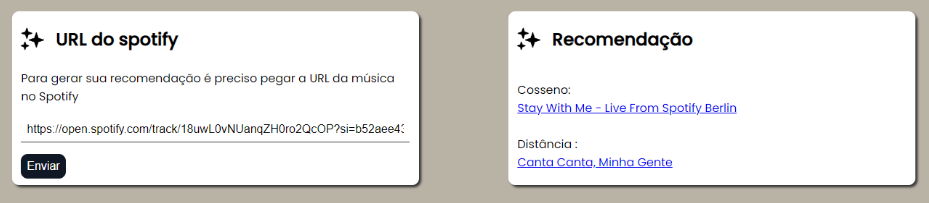

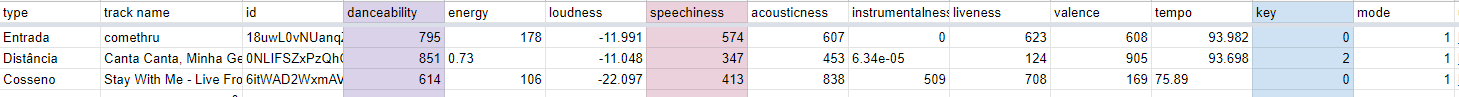


Com base nesse exemplo é possível perceber que os dados se diferem menos quando comparados aos do cosseno com a entrada.


Outro exemplo bom para comprovar a discrepância do erro do cosseno e da distância é esse em que a entrada foi **Electrical Storm - U2** e ele retorna uma música de gênero diferente na distância, sendo gênero semelhante no cosseno

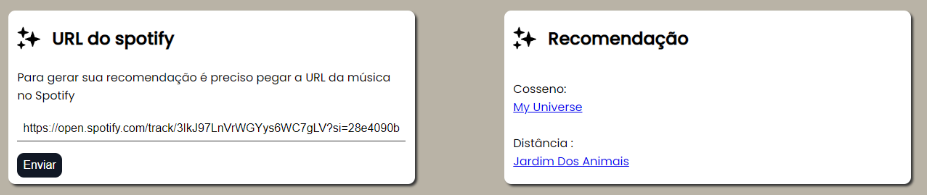

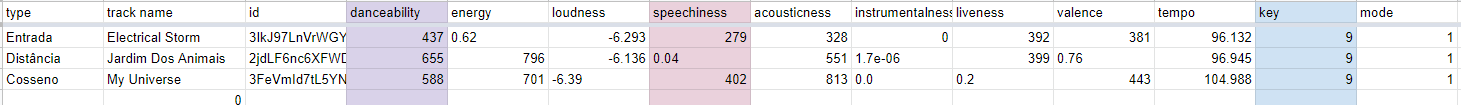

Com base nesses dois exemplos é possível perceber que as features mais determinantes são a danceability, loudness e valence.


Um possível caso que também apareceu algumas vezes foi o algoritmo retorna a mesma música da entrada na distância e no cosseno, como acontece com **Another Love - Tom Odell**, isso acontece porque algumas músicas são duplicadas com *id* diferente, então retorna a mesma 

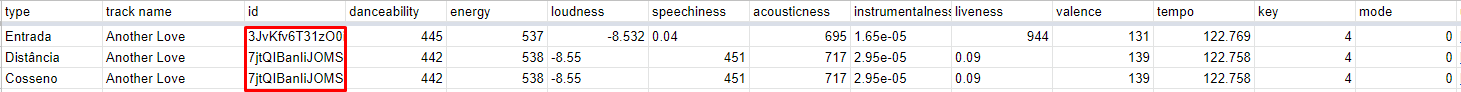